# 03 - EDA and Visualization: Story Trajectory Analysis

This notebook performs exploratory analysis and visualization on the processed outputs using the **Twist Signal** terminology.

## Goals
- Validate data integrity across metadata, features, clusters, and DTW artifacts.
- Build corpus-level and cluster-level views.
- Create book-level Twist Signal deep dives.
- Export reusable figures, tables, and narrative insights.

Note: the same method was historically referred to as "Option B" in older notes; this notebook uses **Twist Signal** as the user-facing name.


In [11]:
# Install required packages if missing
import importlib
import subprocess
import sys

REQUIRED_PACKAGES = [
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("plotly", "plotly"),
    ("sklearn", "scikit-learn"),
]

for module_name, pip_name in REQUIRED_PACKAGES:
    try:
        importlib.import_module(module_name)
    except ImportError:
        print(f"Installing {pip_name} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])

print("Dependency check complete.")


Dependency check complete.


In [12]:
from pathlib import Path
import ast
import json
import textwrap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import MDS

try:
    from IPython.display import display
except Exception:
    def display(x):
        print(x)

SEED = 42
np.random.seed(SEED)

PROJECT_ROOT = Path(".").resolve()
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
OUTPUTS_DIR = PROJECT_ROOT / "outputs"
EDA_DIR = OUTPUTS_DIR / "eda"
FIG_DIR = EDA_DIR / "figures"
TABLE_DIR = EDA_DIR / "tables"

METADATA_PATH = DATA_DIR / "metadata.csv"
FEATURES_PATH = OUTPUTS_DIR / "features.csv"
CLUSTERS_KMEANS_PATH = OUTPUTS_DIR / "clusters_kmeans.csv"
CLUSTERS_HIER_PATH = OUTPUTS_DIR / "clusters_hier.csv"
DTW_PATH = OUTPUTS_DIR / "dtw_distance_k7.npy"

FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12, 6)

print(f"Project root: {PROJECT_ROOT}")
print(f"EDA output dir: {EDA_DIR}")


Project root: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis
EDA output dir: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/eda


## 1) Load + Harmonize Data

In [13]:
def parse_listlike(value):
    if isinstance(value, list):
        return value
    if not isinstance(value, str):
        return value

    s = value.strip()
    if not s.startswith("["):
        return value

    try:
        parsed = json.loads(s)
    except Exception:
        try:
            parsed = ast.literal_eval(s)
        except Exception:
            return value

    return parsed


metadata_df = pd.read_csv(METADATA_PATH)
features_df = pd.read_csv(FEATURES_PATH)
kmeans_df = pd.read_csv(CLUSTERS_KMEANS_PATH)
hier_df = pd.read_csv(CLUSTERS_HIER_PATH)
dtw_matrix = np.load(DTW_PATH)

# Normalize metadata keys
if "id" not in metadata_df.columns and "pg_id" in metadata_df.columns:
    metadata_df["id"] = metadata_df["pg_id"]

if "book_id" not in features_df.columns:
    raise ValueError("features.csv must contain 'book_id'")

for col in ["genre_secondary", "short_tags", "citations"]:
    if col in metadata_df.columns:
        metadata_df[col] = metadata_df[col].apply(parse_listlike)

# Build readable versions for plotting/tooltips
if "genre_secondary" in metadata_df.columns:
    metadata_df["genre_secondary_str"] = metadata_df["genre_secondary"].apply(
        lambda v: ", ".join(v) if isinstance(v, list) else str(v)
    )
if "short_tags" in metadata_df.columns:
    metadata_df["short_tags_str"] = metadata_df["short_tags"].apply(
        lambda v: ", ".join(v) if isinstance(v, list) else str(v)
    )

meta_core_cols = [
    "id", "title", "author", "genre_primary", "format", "origin_country", "original_language",
    "first_publication_year", "recognizability_rank", "genre_clarity_rank", "twist_peak_rank",
    "twist_peak_reason", "processed_dir", "raw_filename",
]
meta_core = metadata_df[[c for c in meta_core_cols if c in metadata_df.columns]].copy().rename(columns={"id": "book_id"})

# Integrity join check
feature_book_ids = set(features_df["book_id"].astype(int).tolist())
meta_book_ids = set(meta_core["book_id"].astype(int).tolist())
missing_in_meta = sorted(feature_book_ids - meta_book_ids)
missing_in_features = sorted(meta_book_ids - feature_book_ids)

if missing_in_meta:
    raise RuntimeError(f"Feature book_ids missing in metadata: {missing_in_meta}")

if missing_in_features:
    print("Warning: metadata has IDs with no features:", missing_in_features)

# Add only metadata columns that are missing in each output table to avoid _x/_y collisions
meta_add_for_features = [c for c in meta_core.columns if c == "book_id" or c not in features_df.columns]
meta_add_for_kmeans = [c for c in meta_core.columns if c == "book_id" or c not in kmeans_df.columns]
meta_add_for_hier = [c for c in meta_core.columns if c == "book_id" or c not in hier_df.columns]

features_enriched = features_df.merge(meta_core[meta_add_for_features], on="book_id", how="left")
kmeans_enriched = kmeans_df.merge(meta_core[meta_add_for_kmeans], on="book_id", how="left")
hier_enriched = hier_df.merge(meta_core[meta_add_for_hier], on="book_id", how="left")

print("Loaded datasets:")
print("- metadata:", metadata_df.shape)
print("- features:", features_df.shape)
print("- kmeans:", kmeans_df.shape)
print("- hierarchical:", hier_df.shape)
print("- dtw matrix:", dtw_matrix.shape)


Loaded datasets:
- metadata: (20, 29)
- features: (60, 35)
- kmeans: (60, 12)
- hierarchical: (80, 13)
- dtw matrix: (20, 20)


## 2) Data Integrity Checks

In [14]:
expected_book_count = 20
expected_k_values = [5, 7, 11]

integrity_rows = []

actual_books = metadata_df["id"].nunique()
integrity_rows.append({"check": "metadata_unique_books", "expected": expected_book_count, "actual": actual_books, "pass": actual_books == expected_book_count})

actual_k_values = sorted(features_df["k"].unique().tolist())
integrity_rows.append({"check": "feature_k_values", "expected": str(expected_k_values), "actual": str(actual_k_values), "pass": actual_k_values == expected_k_values})

expected_feature_rows = actual_books * len(expected_k_values)
integrity_rows.append({"check": "feature_row_count", "expected": expected_feature_rows, "actual": len(features_df), "pass": len(features_df) == expected_feature_rows})

dtw_square = dtw_matrix.ndim == 2 and dtw_matrix.shape[0] == dtw_matrix.shape[1]
integrity_rows.append({"check": "dtw_square", "expected": True, "actual": bool(dtw_square), "pass": bool(dtw_square)})

dtw_symmetric = bool(np.allclose(dtw_matrix, dtw_matrix.T, atol=1e-6)) if dtw_square else False
integrity_rows.append({"check": "dtw_symmetric", "expected": True, "actual": dtw_symmetric, "pass": dtw_symmetric})

dtw_diag_zero = bool(np.allclose(np.diag(dtw_matrix), 0.0, atol=1e-6)) if dtw_square else False
integrity_rows.append({"check": "dtw_diag_zero", "expected": True, "actual": dtw_diag_zero, "pass": dtw_diag_zero})

integrity_df = pd.DataFrame(integrity_rows)
integrity_df.to_csv(TABLE_DIR / "integrity_checks.csv", index=False)

if not integrity_df["pass"].all():
    failed = integrity_df[~integrity_df["pass"]]
    raise RuntimeError(f"Integrity checks failed:\n{failed}")

print("All integrity checks passed.")
display(integrity_df)


All integrity checks passed.


,check,expected,actual,pass
0,metadata_unique_books,20,20,True
1,feature_k_values,"[5, 7, 11]","[5, 7, 11]",True
2,feature_row_count,60,60,True
3,dtw_square,True,True,True
4,dtw_symmetric,True,True,True
5,dtw_diag_zero,True,True,True


## 3) Corpus Composition EDA

/var/folders/2m/my6rfccj2lqgy6_6y84lqwsw0000gn/T/ipykernel_78528/1320001897.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2m/my6rfccj2lqgy6_6y84lqwsw0000gn/T/ipykernel_78528/1320001897.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2m/my6rfccj2lqgy6_6y84lqwsw0000gn/T/ipykernel_78528/1320001897.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2m/my6rfccj2lqgy6_6y84lqwsw0000gn/T/ipykernel_78528/1320001897.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

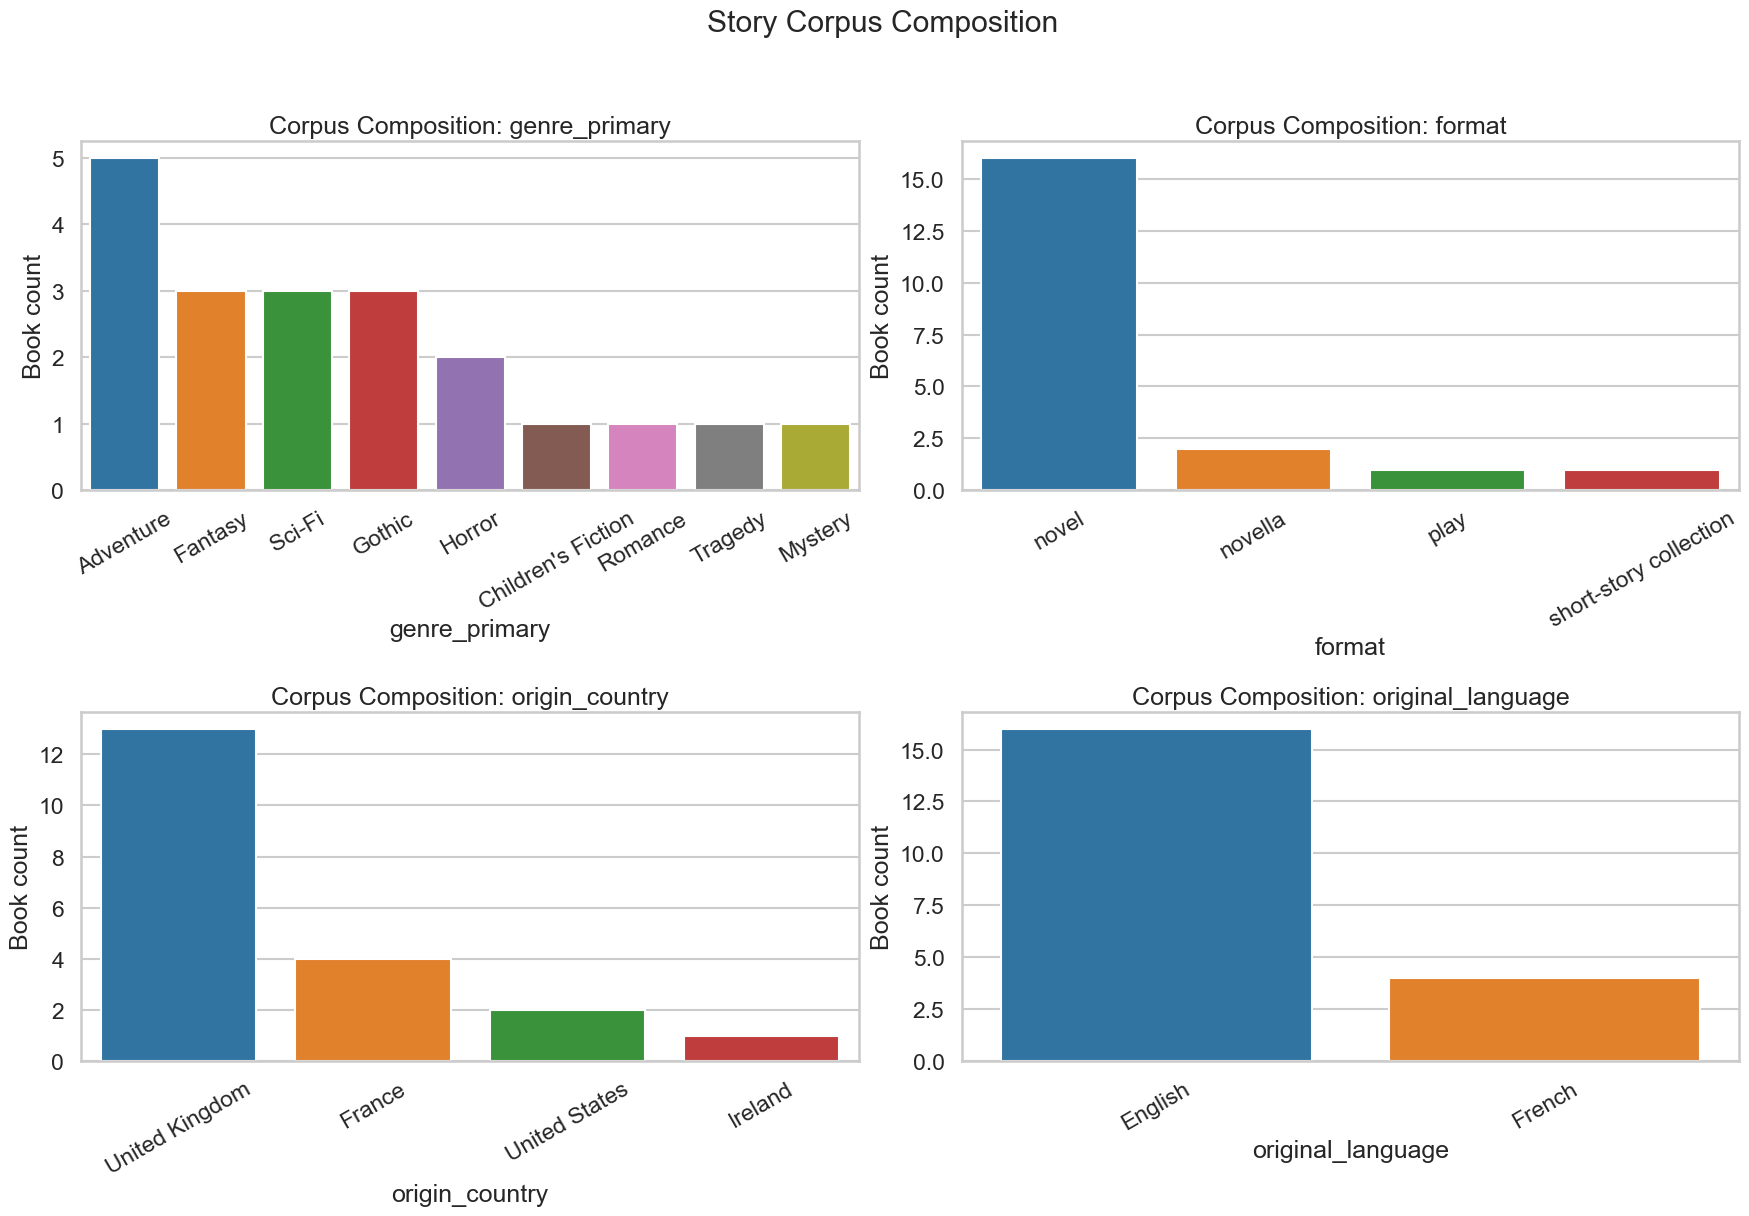

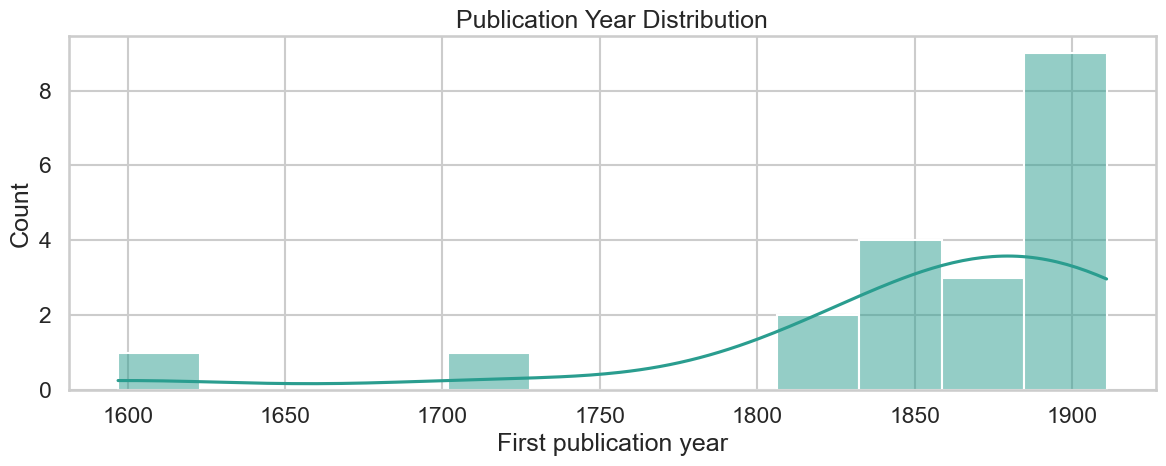

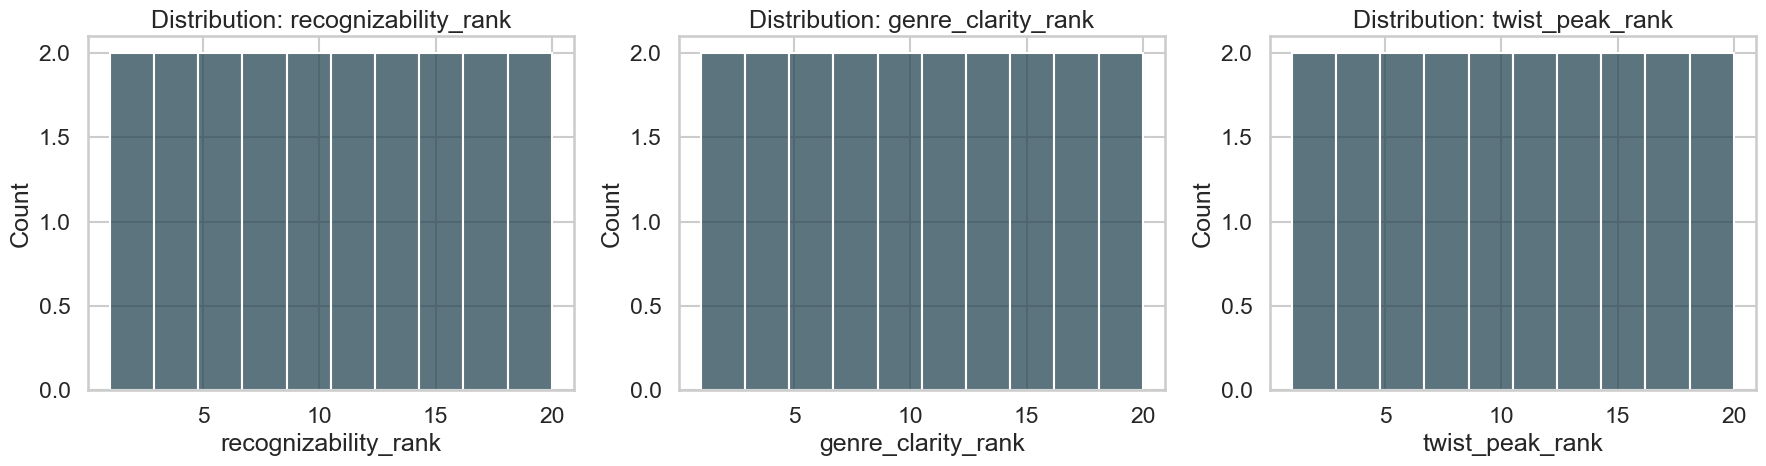

,genre_primary,format,book_count
0,Adventure,novel,5
2,Fantasy,novel,3
3,Gothic,novel,3
8,Sci-Fi,novel,2
1,Children's Fiction,novel,1
4,Horror,novel,1
5,Horror,novella,1
6,Mystery,short-story collection,1
7,Romance,novel,1
9,Sci-Fi,novella,1


In [15]:
corpus_df = metadata_df.copy()

# 1) Categorical composition
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plot_cols = ["genre_primary", "format", "origin_country", "original_language"]
for ax, col in zip(axes.flatten(), plot_cols):
    order = corpus_df[col].value_counts().index
    sns.countplot(data=corpus_df, x=col, order=order, ax=ax, palette="tab10")
    ax.set_title(f"Corpus Composition: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Book count")
    ax.tick_params(axis="x", rotation=30)

fig.suptitle("Story Corpus Composition", y=1.02)
fig.tight_layout()
fig.savefig(FIG_DIR / "corpus_composition_counts.png", dpi=160, bbox_inches="tight")
plt.show()

# 2) Publication year distribution
plt.figure(figsize=(12, 5))
sns.histplot(corpus_df["first_publication_year"], bins=12, kde=True, color="#2a9d8f")
plt.title("Publication Year Distribution")
plt.xlabel("First publication year")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "publication_year_distribution.png", dpi=160, bbox_inches="tight")
plt.show()

# 3) Rank distributions
rank_cols = ["recognizability_rank", "genre_clarity_rank", "twist_peak_rank"]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, col in zip(axes, rank_cols):
    sns.histplot(corpus_df[col], bins=10, kde=False, ax=ax, color="#264653")
    ax.set_title(f"Distribution: {col}")
    ax.set_xlabel(col)

fig.tight_layout()
fig.savefig(FIG_DIR / "metadata_rank_distributions.png", dpi=160, bbox_inches="tight")
plt.show()

corpus_summary = corpus_df.groupby(["genre_primary", "format"]).size().reset_index(name="book_count")
corpus_summary.to_csv(TABLE_DIR / "corpus_genre_format_counts.csv", index=False)
display(corpus_summary.sort_values("book_count", ascending=False).head(20))


## 4) Twist Signal Feature EDA

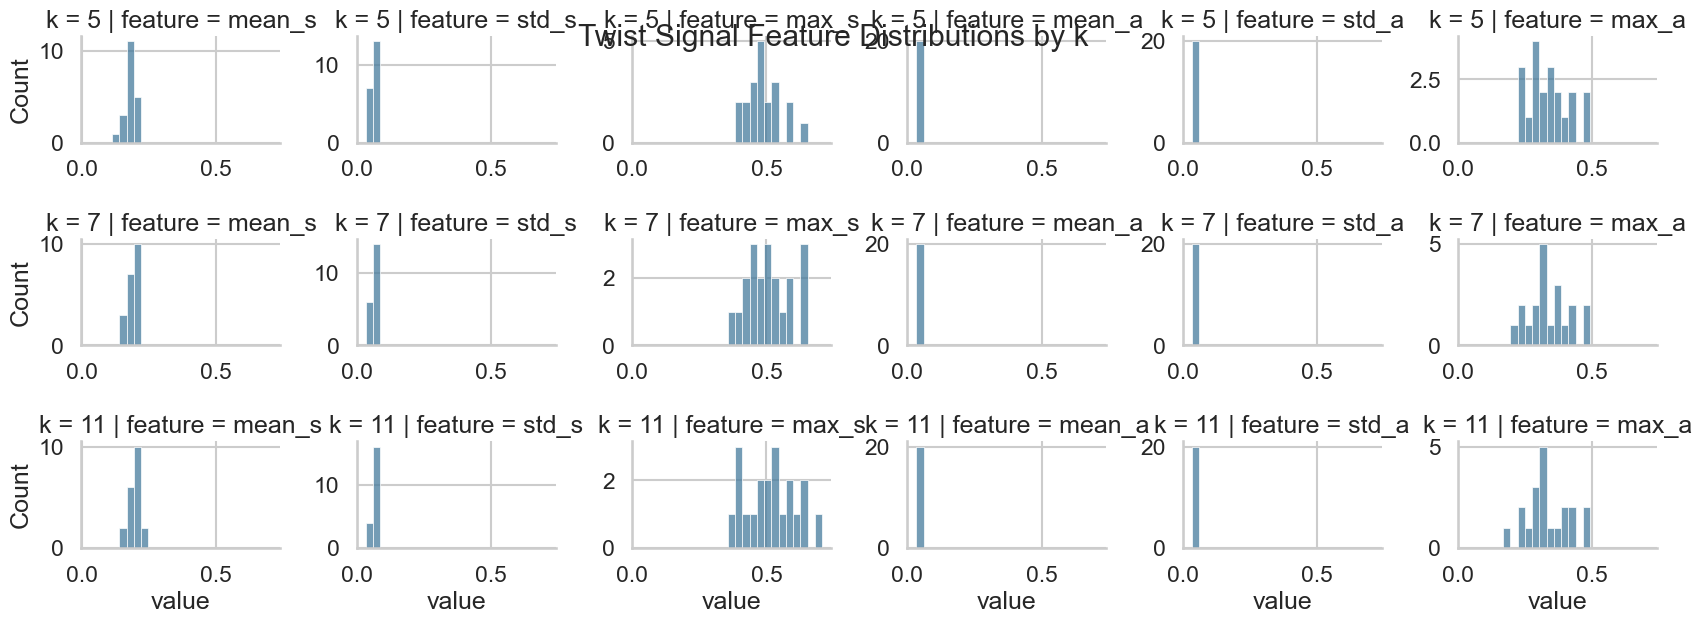

/var/folders/2m/my6rfccj2lqgy6_6y84lqwsw0000gn/T/ipykernel_78528/137746487.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2m/my6rfccj2lqgy6_6y84lqwsw0000gn/T/ipykernel_78528/137746487.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2m/my6rfccj2lqgy6_6y84lqwsw0000gn/T/ipykernel_78528/137746487.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/2m/my6rfccj2lqgy6_6y84lqwsw0000gn/T/ipykernel_78528/137746487.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

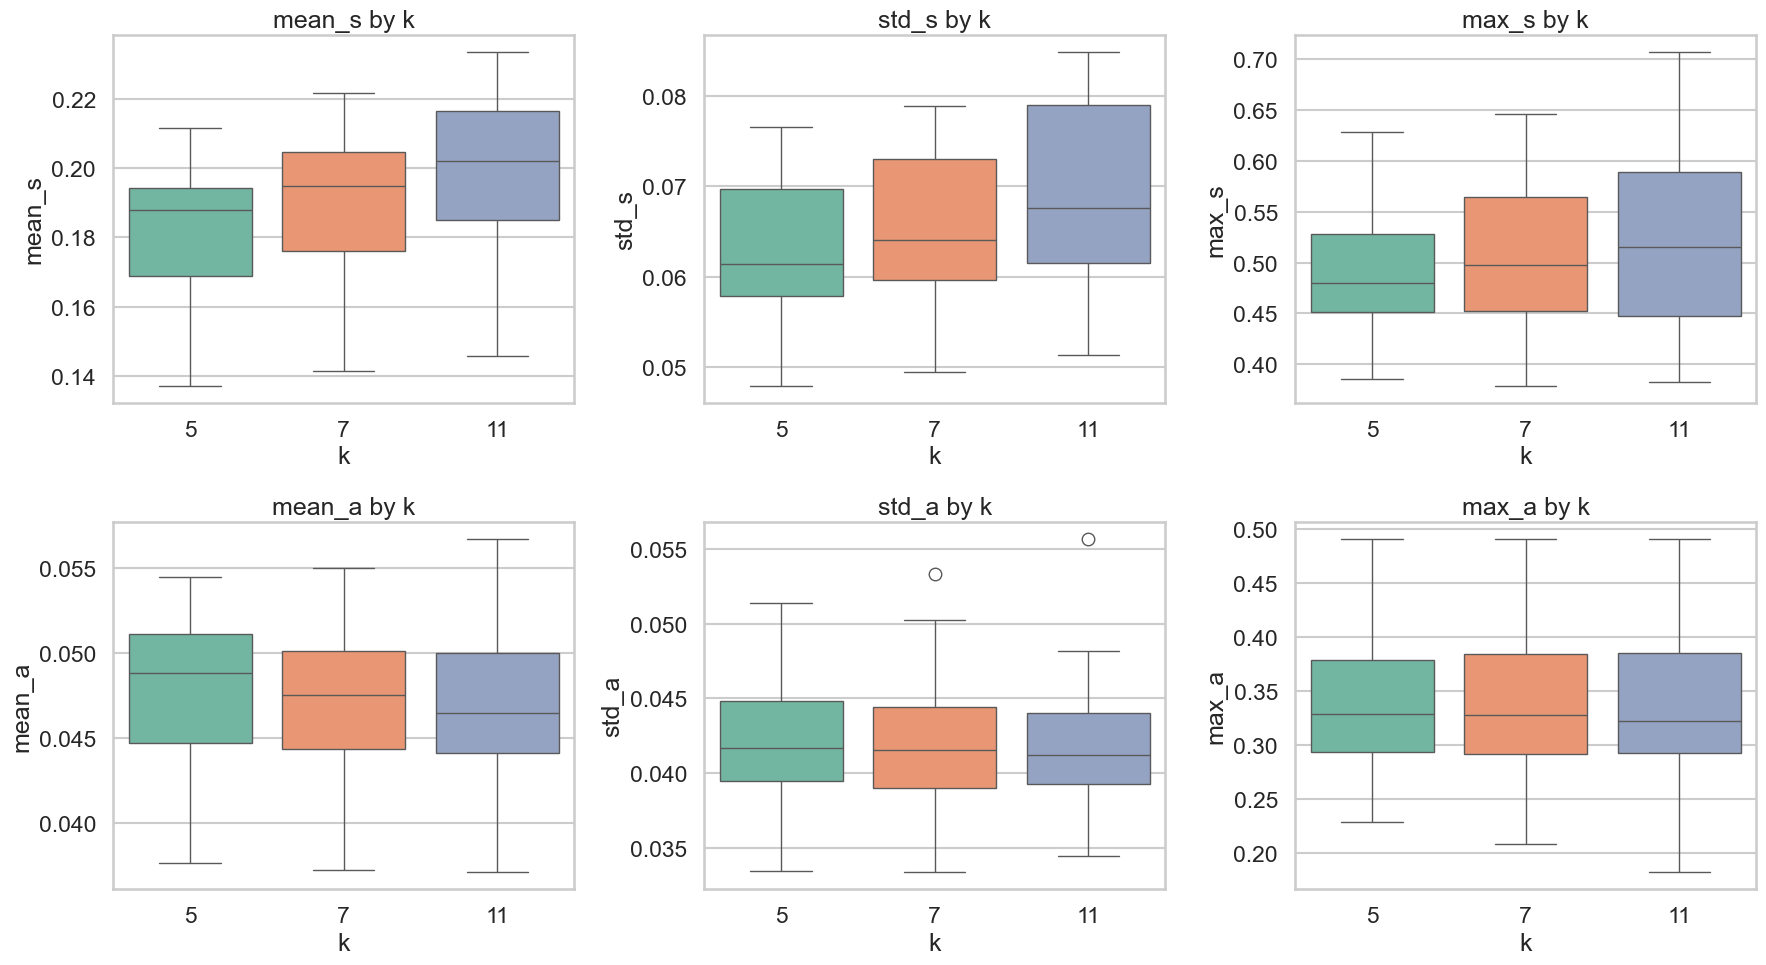

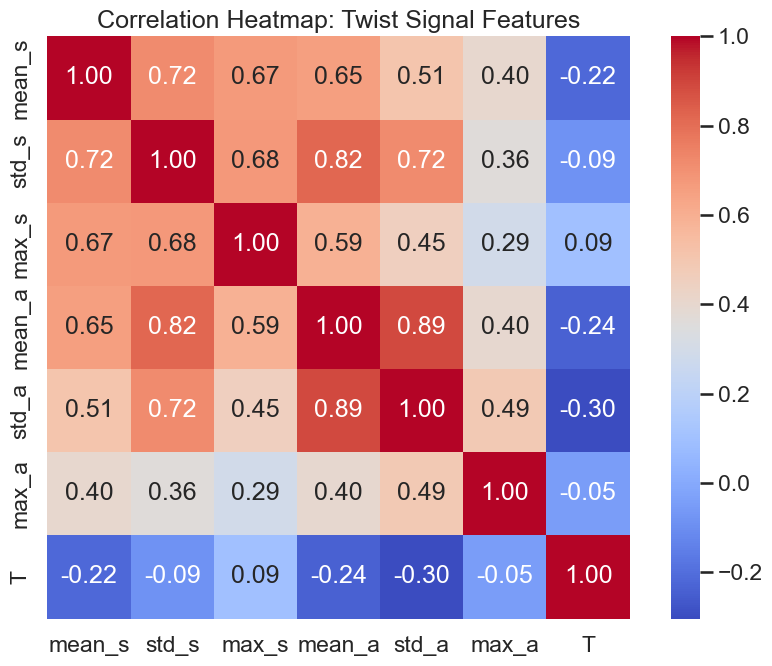

In [16]:
twist_feature_cols = ["mean_s", "std_s", "max_s", "mean_a", "std_a", "max_a"]

# Long form for facet plotting
long_df = features_enriched.melt(
    id_vars=["book_id", "k", "title", "genre_primary", "format"],
    value_vars=twist_feature_cols,
    var_name="feature",
    value_name="value",
)

# Histograms by k
g = sns.displot(
    data=long_df,
    x="value",
    col="feature",
    row="k",
    facet_kws={"sharex": False, "sharey": False},
    bins=25,
    height=2.1,
    aspect=1.35,
    color="#457b9d",
)
g.fig.subplots_adjust(top=0.96)
g.fig.suptitle("Twist Signal Feature Distributions by k")
g.savefig(FIG_DIR / "twist_signal_feature_hist_by_k.png", dpi=160)
plt.show()

# Boxplots by k
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for ax, col in zip(axes.flatten(), twist_feature_cols):
    sns.boxplot(data=features_enriched, x="k", y=col, ax=ax, palette="Set2")
    ax.set_title(f"{col} by k")
fig.tight_layout()
fig.savefig(FIG_DIR / "twist_signal_feature_boxplots_by_k.png", dpi=160, bbox_inches="tight")
plt.show()

# Correlation heatmap
corr_cols = twist_feature_cols + ["T"]
corr = features_enriched[corr_cols].corr(numeric_only=True)
plt.figure(figsize=(9, 7))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap: Twist Signal Features")
plt.tight_layout()
plt.savefig(FIG_DIR / "twist_signal_feature_correlation_heatmap.png", dpi=160, bbox_inches="tight")
plt.show()

# Interactive scatter
scatter_df = features_enriched[features_enriched["k"] == 7].copy()
fig = px.scatter(
    scatter_df,
    x="mean_s",
    y="std_a",
    color="genre_primary",
    symbol="format",
    hover_data=["book_id", "title", "author", "twist_peak_rank", "recognizability_rank"],
    title="Twist Signal View (k=7): mean_s vs std_a",
)
fig.write_html(FIG_DIR / "interactive_twist_signal_scatter_k7.html", include_plotlyjs="cdn")
fig.show()


## 5) Cluster Analysis

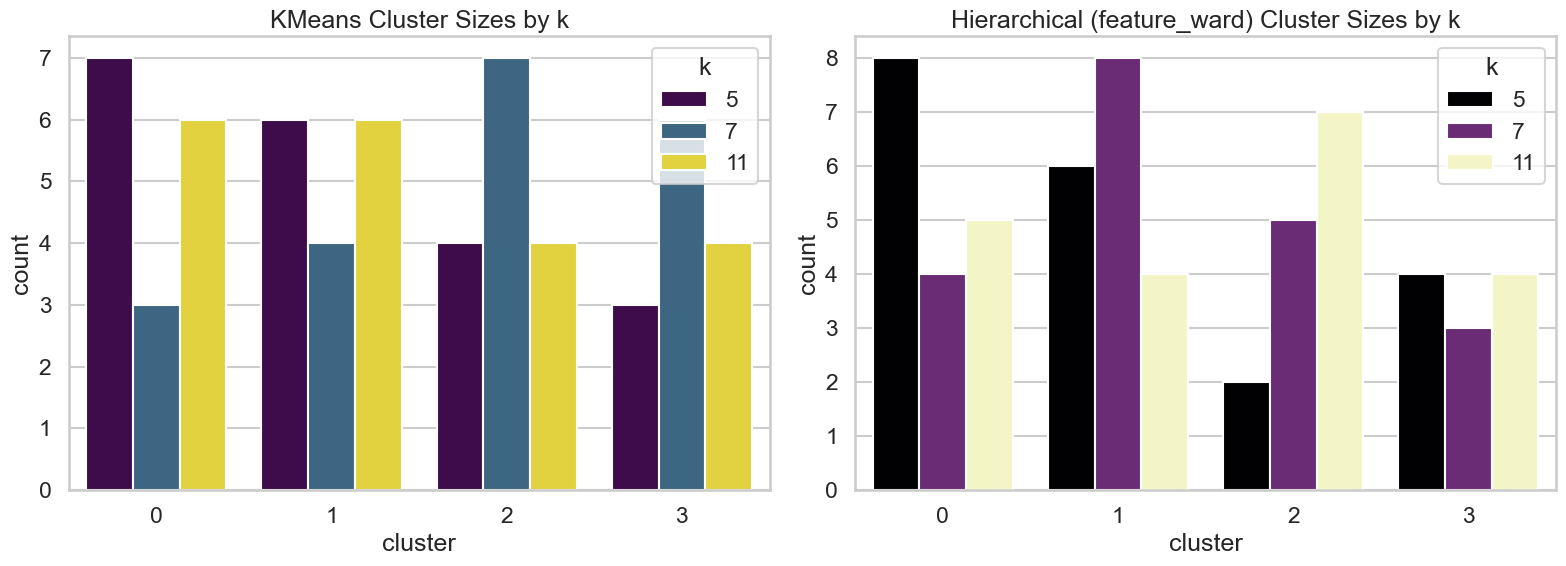

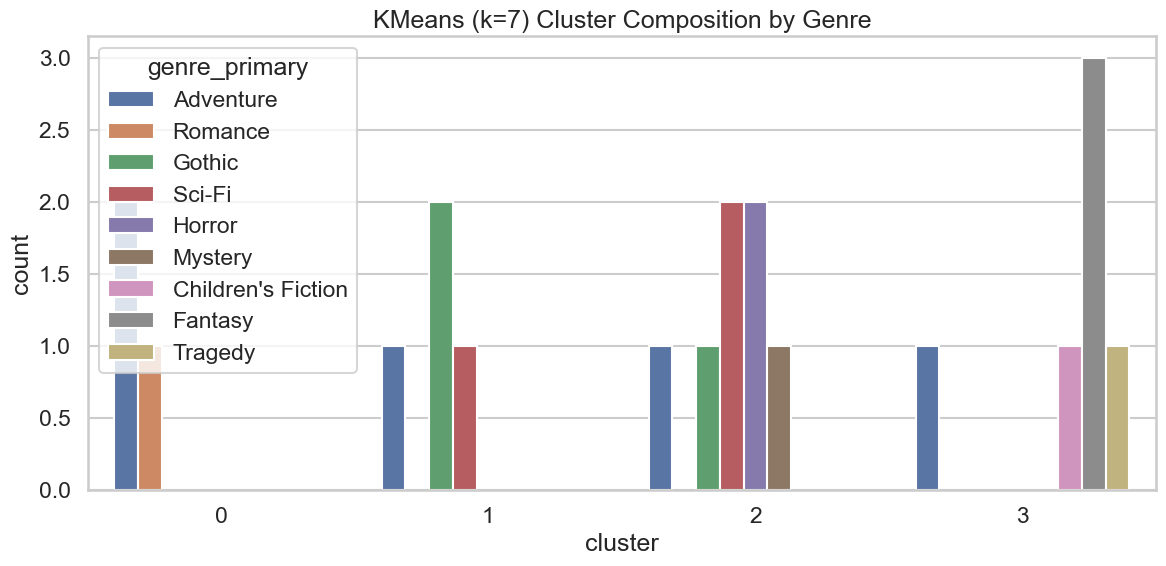

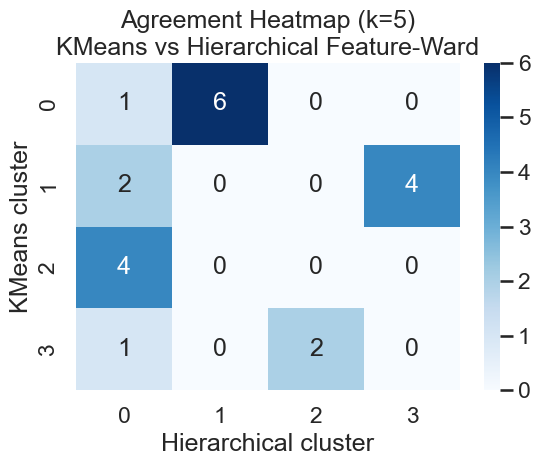

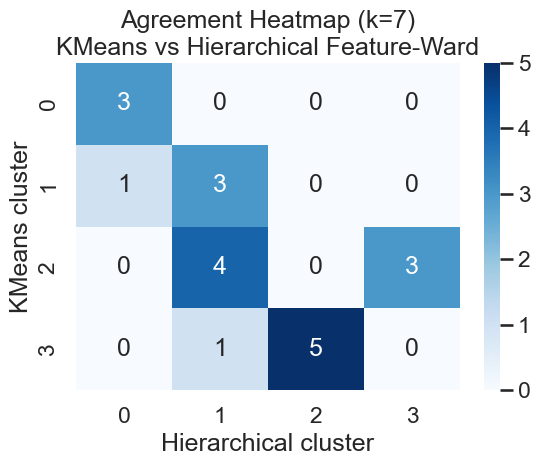

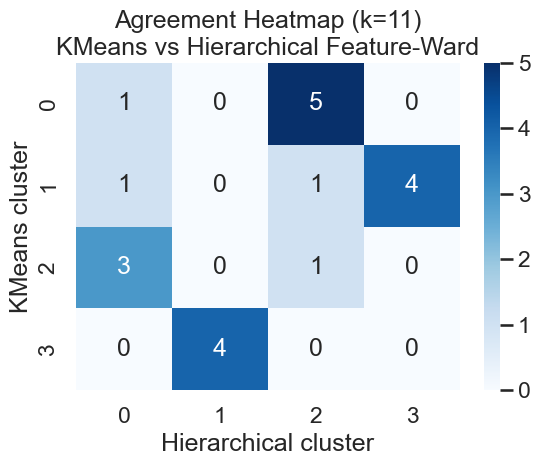

,k,naive_diagonal_ratio
0,5,0.05
1,7,0.30
2,11,0.10


DTW cluster perspective (k=7):


,k,cluster,count
0,7,0,17
1,7,1,1
2,7,2,1
3,7,3,1


In [17]:
# Cluster size by method and k
kmeans_counts = kmeans_enriched.groupby(["k", "cluster"]).size().reset_index(name="count")
ward_counts = hier_enriched[hier_enriched["mode"] == "feature_ward"].groupby(["k", "cluster"]).size().reset_index(name="count")
dtw_counts = hier_enriched[hier_enriched["mode"] == "dtw_average"].groupby(["k", "cluster"]).size().reset_index(name="count")

kmeans_counts.to_csv(TABLE_DIR / "kmeans_cluster_counts.csv", index=False)
ward_counts.to_csv(TABLE_DIR / "hier_feature_ward_cluster_counts.csv", index=False)
dtw_counts.to_csv(TABLE_DIR / "hier_dtw_cluster_counts.csv", index=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=kmeans_counts, x="cluster", y="count", hue="k", ax=axes[0], palette="viridis")
axes[0].set_title("KMeans Cluster Sizes by k")

sns.barplot(data=ward_counts, x="cluster", y="count", hue="k", ax=axes[1], palette="magma")
axes[1].set_title("Hierarchical (feature_ward) Cluster Sizes by k")

fig.tight_layout()
fig.savefig(FIG_DIR / "cluster_sizes_kmeans_vs_hier_feature_ward.png", dpi=160, bbox_inches="tight")
plt.show()

# Metadata composition per cluster (k=7)
k7 = kmeans_enriched[kmeans_enriched["k"] == 7].copy()
composition = k7.groupby(["cluster", "genre_primary"]).size().reset_index(name="count")
composition.to_csv(TABLE_DIR / "kmeans_k7_genre_composition.csv", index=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=composition, x="cluster", y="count", hue="genre_primary")
plt.title("KMeans (k=7) Cluster Composition by Genre")
plt.tight_layout()
plt.savefig(FIG_DIR / "kmeans_k7_cluster_genre_composition.png", dpi=160, bbox_inches="tight")
plt.show()

# Agreement: KMeans vs feature_ward
agreement_tables = []
for kval in sorted(features_enriched["k"].unique()):
    a = kmeans_enriched[kmeans_enriched["k"] == kval][["book_id", "cluster"]].rename(columns={"cluster": "kmeans_cluster"})
    b = hier_enriched[(hier_enriched["k"] == kval) & (hier_enriched["mode"] == "feature_ward")][["book_id", "cluster"]].rename(columns={"cluster": "ward_cluster"})
    merged = a.merge(b, on="book_id", how="inner")
    ctab = pd.crosstab(merged["kmeans_cluster"], merged["ward_cluster"])
    ctab.to_csv(TABLE_DIR / f"agreement_k{kval}_kmeans_vs_ward.csv")

    plt.figure(figsize=(6, 5))
    sns.heatmap(ctab, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Agreement Heatmap (k={kval})\nKMeans vs Hierarchical Feature-Ward")
    plt.xlabel("Hierarchical cluster")
    plt.ylabel("KMeans cluster")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"agreement_heatmap_k{kval}_kmeans_vs_ward.png", dpi=160, bbox_inches="tight")
    plt.show()

    agreement_score = np.trace(ctab.values) / ctab.values.sum() if ctab.values.sum() > 0 else np.nan
    agreement_tables.append({"k": int(kval), "naive_diagonal_ratio": float(agreement_score)})

agreement_df = pd.DataFrame(agreement_tables)
agreement_df.to_csv(TABLE_DIR / "agreement_summary_kmeans_vs_ward.csv", index=False)
display(agreement_df)

print("DTW cluster perspective (k=7):")
display(dtw_counts)

## 6) DTW Structure Visuals

,book_id,book_title,neighbor_rank,neighbor_book_id,neighbor_title,dtw_distance
0,11,Alice's Adventures in Wonderland,1,120,Treasure Island,0.464294
1,11,Alice's Adventures in Wonderland,2,1513,Romeo and Juliet,0.483125
2,11,Alice's Adventures in Wonderland,3,16,Peter Pan,0.515819
3,16,Peter Pan,1,120,Treasure Island,0.511781
4,16,Peter Pan,2,11,Alice's Adventures in Wonderland,0.515819
5,16,Peter Pan,3,1513,Romeo and Juliet,0.551243
6,35,The Time Machine,1,11,Alice's Adventures in Wonderland,0.613170
7,35,The Time Machine,2,16,Peter Pan,0.639234
8,35,The Time Machine,3,120,Treasure Island,0.646933
9,36,The War of the Worlds,1,11,Alice's Adventures in Wonderland,0.557455


/Users/kongfha/miniconda3/envs/work313/lib/python3.13/site-packages/sklearn/manifold/_mds.py:744: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.

/Users/kongfha/miniconda3/envs/work313/lib/python3.13/site-packages/sklearn/manifold/_mds.py:754: FutureWarning:

The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.

/Users/kongfha/miniconda3/envs/work313/lib/python3.13/site-packages/sklearn/manifold/_mds.py:771: FutureWarning:

The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.



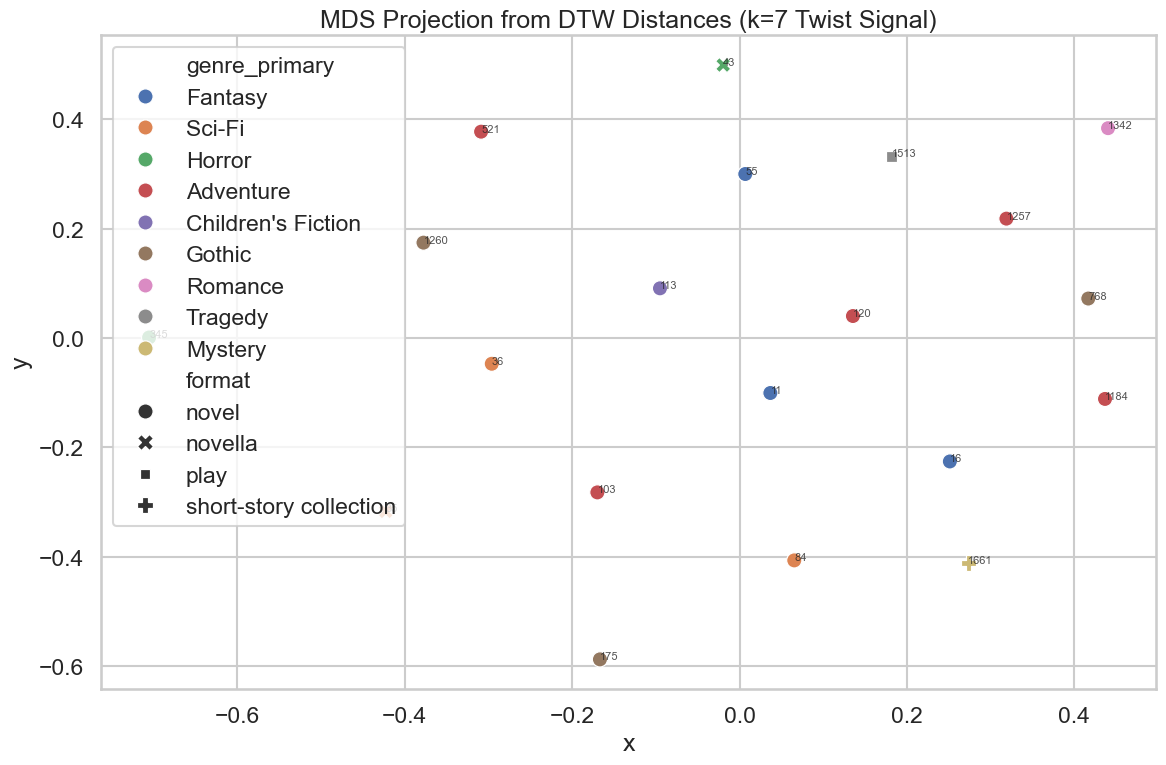

In [18]:
# Build label order from metadata IDs sorted numerically
meta_sorted = metadata_df.sort_values("id").copy()
book_ids_sorted = meta_sorted["id"].astype(int).tolist()
book_labels = [f"{bid} | {title}" for bid, title in zip(meta_sorted["id"], meta_sorted["title"])]

# DTW heatmap (interactive)
fig = go.Figure(
    data=go.Heatmap(
        z=dtw_matrix,
        x=book_labels,
        y=book_labels,
        colorscale="Viridis",
        colorbar=dict(title="DTW distance"),
    )
)
fig.update_layout(title="DTW Distance Matrix (k=7 Twist Signal)", width=950, height=850)
fig.write_html(FIG_DIR / "dtw_heatmap_k7.html", include_plotlyjs="cdn")
fig.show()

# Nearest neighbors table
n = dtw_matrix.shape[0]
neighbors = []
for i in range(n):
    row = dtw_matrix[i].copy().astype(float)
    row[i] = np.inf
    idx_sorted = np.argsort(row)[:3]
    for rank, j in enumerate(idx_sorted, start=1):
        neighbors.append({
            "book_id": int(book_ids_sorted[i]),
            "book_title": str(meta_sorted.iloc[i]["title"]),
            "neighbor_rank": int(rank),
            "neighbor_book_id": int(book_ids_sorted[j]),
            "neighbor_title": str(meta_sorted.iloc[j]["title"]),
            "dtw_distance": float(dtw_matrix[i, j]),
        })

nn_df = pd.DataFrame(neighbors)
nn_df.to_csv(TABLE_DIR / "dtw_top3_neighbors_k7.csv", index=False)
display(nn_df.head(15))

# MDS projection from DTW matrix
mds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    random_state=SEED,
    normalized_stress="auto",
)
coords = mds.fit_transform(dtw_matrix)
mds_df = pd.DataFrame({
    "book_id": book_ids_sorted,
    "x": coords[:, 0],
    "y": coords[:, 1],
}).merge(meta_sorted[["id", "title", "genre_primary", "format"]], left_on="book_id", right_on="id", how="left")
mds_df.to_csv(TABLE_DIR / "dtw_mds_projection.csv", index=False)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=mds_df, x="x", y="y", hue="genre_primary", style="format", s=120)
for _, row in mds_df.iterrows():
    plt.text(row["x"], row["y"], str(row["book_id"]), fontsize=8, alpha=0.8)
plt.title("MDS Projection from DTW Distances (k=7 Twist Signal)")
plt.tight_layout()
plt.savefig(FIG_DIR / "dtw_mds_projection.png", dpi=160, bbox_inches="tight")
plt.show()

fig2 = px.scatter(
    mds_df,
    x="x",
    y="y",
    color="genre_primary",
    symbol="format",
    hover_data=["book_id", "title"],
    title="Interactive MDS Projection from DTW Distances",
)
fig2.write_html(FIG_DIR / "interactive_dtw_mds_projection.html", include_plotlyjs="cdn")
fig2.show()


## 7) Book-Level Twist Signal Deep Dives

,cluster,book_id,title,processed_dir,twist_peak_reason,genre_primary,format
0,0,1184,The Count of Monte Cristo,count_monte_cristo,"Packed with shocking reveals, sudden betrayals...",Adventure,novel
1,1,36,The War of the Worlds,war_worlds,The sudden defeat of the seemingly invincible ...,Sci-Fi,novel
2,2,35,The Time Machine,time_machine,The revelation of the predatory Morlocks feedi...,Sci-Fi,novella
3,3,11,Alice's Adventures in Wonderland,alice_s_adventures_wonderland,Picaresque and episodic structure; the 'it was...,Fantasy,novel


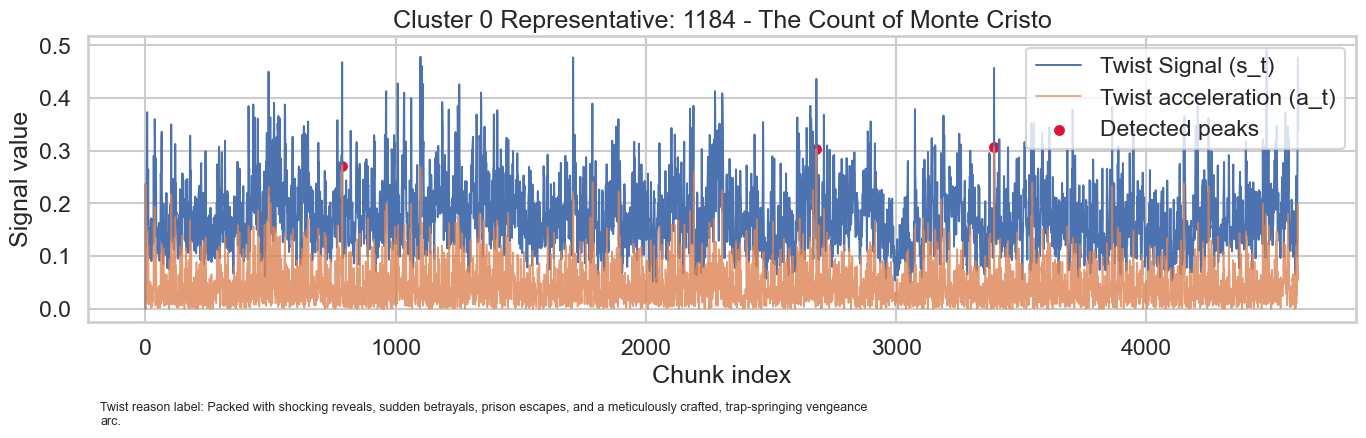

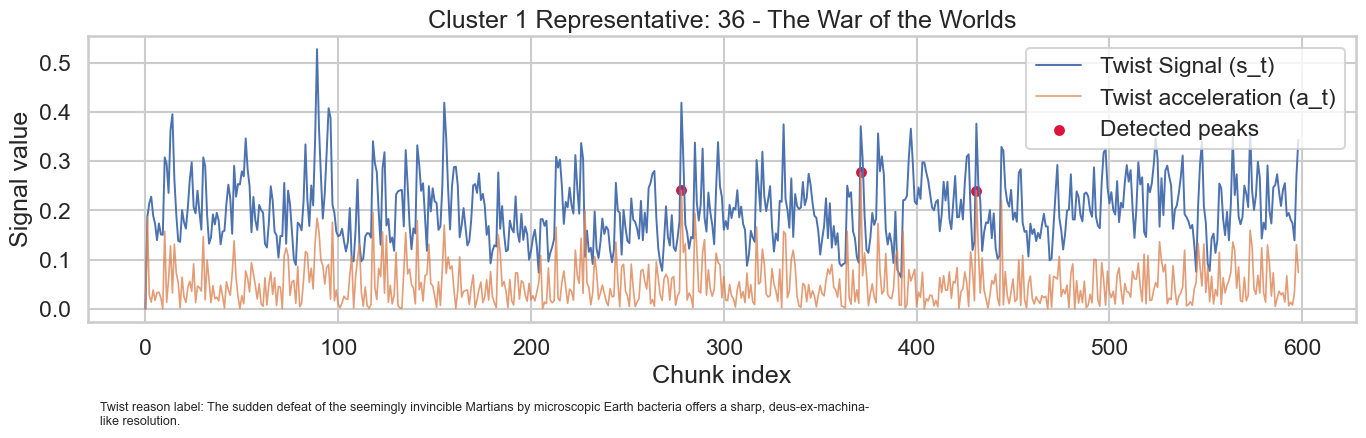

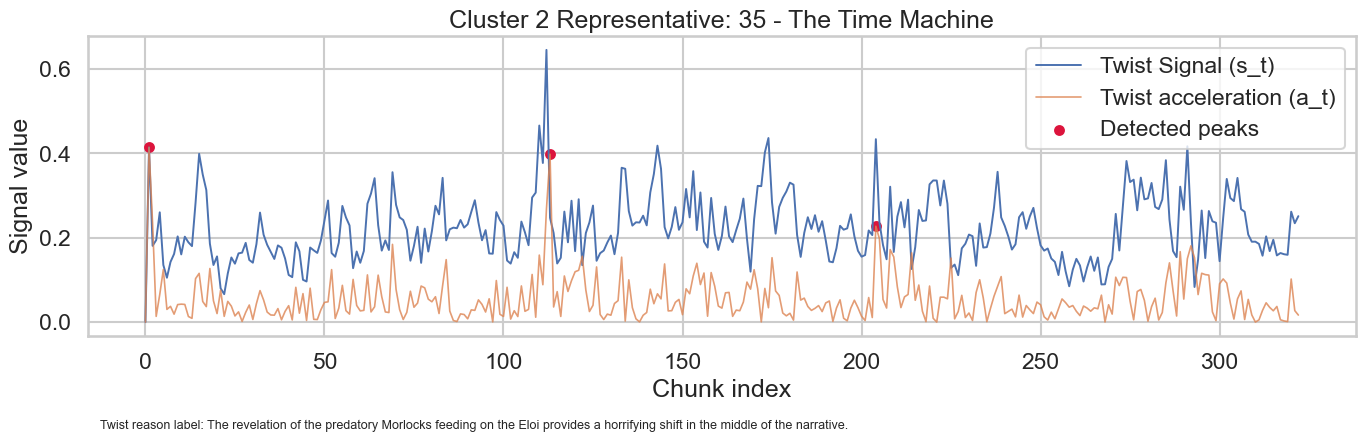

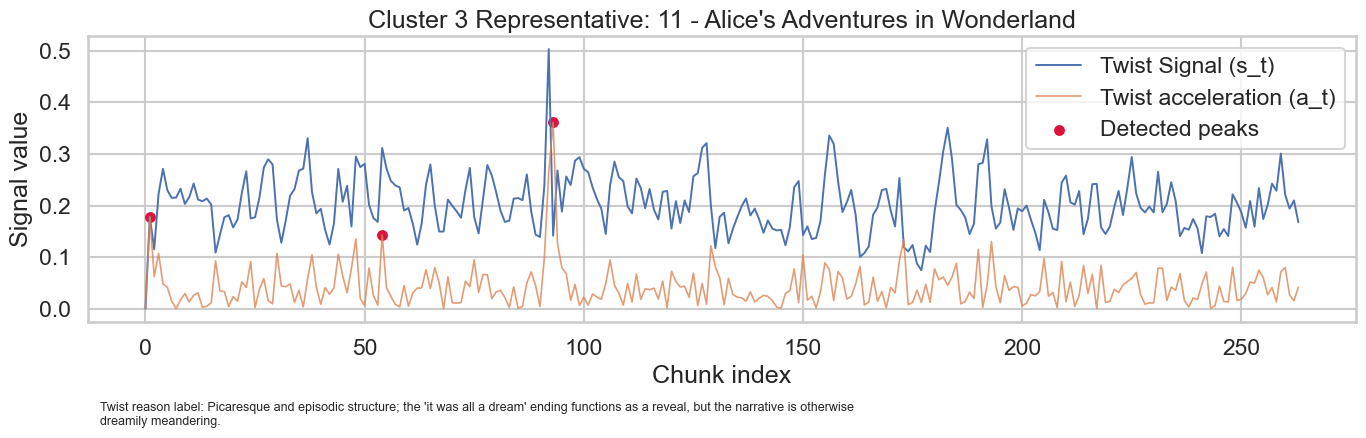

In [19]:
# Select representative books per KMeans cluster at k=7 (deterministic: smallest book_id per cluster)
k7_clusters = kmeans_enriched[kmeans_enriched["k"] == 7].copy().sort_values(["cluster", "book_id"])
rep_books = k7_clusters.groupby("cluster", as_index=False).first()
rep_books = rep_books[["cluster", "book_id", "title", "processed_dir", "twist_peak_reason", "genre_primary", "format"]]
rep_books.to_csv(TABLE_DIR / "representative_books_kmeans_k7.csv", index=False)
display(rep_books)


def load_signal_and_peaks(book_id: int, processed_dir: str, k: int = 7):
    base = PROCESSED_DIR / str(processed_dir)
    sig = np.load(base / f"signals_k{k}.npz")
    s = sig["s"]
    a = sig["a"]
    peaks_path = base / f"peaks_k{k}.json"
    peaks = json.loads(peaks_path.read_text(encoding="utf-8")) if peaks_path.exists() else {"peak_indices": []}
    peak_indices = peaks.get("peak_indices", [])
    return s, a, peak_indices


for _, row in rep_books.iterrows():
    book_id = int(row["book_id"])
    title = str(row["title"])
    processed_dir = str(row["processed_dir"])
    cluster = int(row["cluster"])

    s, a, peak_indices = load_signal_and_peaks(book_id=book_id, processed_dir=processed_dir, k=7)
    t = np.arange(len(s))

    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(t, s, label="Twist Signal (s_t)", linewidth=1.4)
    ax.plot(t, a, label="Twist acceleration (a_t)", linewidth=1.2, alpha=0.8)

    if peak_indices:
        peak_indices = [int(x) for x in peak_indices if 0 <= int(x) < len(a)]
        ax.scatter(peak_indices, a[peak_indices], color="crimson", s=40, label="Detected peaks")

    ax.set_title(f"Cluster {cluster} Representative: {book_id} - {title}")
    ax.set_xlabel("Chunk index")
    ax.set_ylabel("Signal value")
    ax.legend(loc="upper right")

    twist_reason = str(row.get("twist_peak_reason", ""))
    wrapped = textwrap.fill(twist_reason, width=120)
    ax.text(0.01, -0.28, f"Twist reason label: {wrapped}", transform=ax.transAxes, fontsize=9, va="top")

    fig.tight_layout()
    fig.savefig(FIG_DIR / f"twist_signal_deep_dive_book_{book_id}_k7.png", dpi=160, bbox_inches="tight")
    plt.show()


## 8) Insight Extraction + Exports

In [20]:
# Build concise exploratory + deeper interpretation notes
k7 = features_enriched[features_enriched["k"] == 7].copy()

high_mean_s = k7.nlargest(3, "mean_s")[["book_id", "title", "mean_s", "genre_primary"]]
high_max_a = k7.nlargest(3, "max_a")[["book_id", "title", "max_a", "genre_primary"]]
low_mean_s = k7.nsmallest(3, "mean_s")[["book_id", "title", "mean_s", "genre_primary"]]

cluster_genre_mix = (
    kmeans_enriched[kmeans_enriched["k"] == 7]
    .groupby(["cluster", "genre_primary"]).size()
    .reset_index(name="count")
    .sort_values(["cluster", "count"], ascending=[True, False])
)

def nearest_neighbor_mean(distance_matrix: np.ndarray):
    n = distance_matrix.shape[0]
    vals = []
    for i in range(n):
        row = distance_matrix[i].astype(float).copy()
        row[i] = np.inf
        vals.append(np.min(row))
    return float(np.mean(vals))

exploratory_points = [
    f"k=7 mean_s ranges from {k7['mean_s'].min():.3f} to {k7['mean_s'].max():.3f} across books.",
    f"k=7 max_a ranges from {k7['max_a'].min():.3f} to {k7['max_a'].max():.3f}.",
    f"DTW distance matrix mean is {dtw_matrix.mean():.3f} with nearest-neighbor mean {nearest_neighbor_mean(dtw_matrix):.3f}.",
    "Feature-based clusters are more balanced than DTW-average hierarchical clusters in current settings.",
]

deeper_points = [
    "Hypothesis (Medium confidence): books with higher max_a show sharper local narrative transitions and may correspond to stronger labeled twist intensity.",
    "Hypothesis (Medium confidence): feature-space clusters separate multiple trajectory regimes, while DTW-average currently collapses many books into a dominant basin.",
    "Hypothesis (Low confidence): genre labels partially align with trajectory clusters, but overlap suggests shared pacing motifs across genres.",
]

caveats = [
    "Caveat: clustering defaults are baseline and not hyperparameter-optimized.",
    "Caveat: interpretations should be rechecked across k values and alternative distance/linkage settings.",
    "Caveat: metadata rank labels are helpful but subjective and should not be treated as strict ground truth.",
]

insights_lines = [
    "# EDA Insights: Twist Signal",
    "",
    "## Exploratory Observations",
]
insights_lines.extend([f"- {p}" for p in exploratory_points])
insights_lines.extend([
    "",
    "Top books by mean_s (k=7):",
])
for _, r in high_mean_s.iterrows():
    insights_lines.append(f"- {int(r['book_id'])} | {r['title']} | mean_s={r['mean_s']:.3f} | genre={r['genre_primary']}")

insights_lines.extend([
    "",
    "Top books by max_a (k=7):",
])
for _, r in high_max_a.iterrows():
    insights_lines.append(f"- {int(r['book_id'])} | {r['title']} | max_a={r['max_a']:.3f} | genre={r['genre_primary']}")

insights_lines.extend([
    "",
    "Low mean_s books (k=7):",
])
for _, r in low_mean_s.iterrows():
    insights_lines.append(f"- {int(r['book_id'])} | {r['title']} | mean_s={r['mean_s']:.3f} | genre={r['genre_primary']}")

insights_lines.extend([
    "",
    "## Deeper Interpretation Hypotheses",
])
insights_lines.extend([f"- {p}" for p in deeper_points])

insights_lines.extend([
    "",
    "## Caveats and Validation Next Steps",
])
insights_lines.extend([f"- {c}" for c in caveats])

insights_text = "\n".join(insights_lines) + "\n"
insights_path = EDA_DIR / "insights.md"
insights_path.write_text(insights_text, encoding="utf-8")

cluster_genre_mix.to_csv(TABLE_DIR / "cluster_genre_mix_kmeans_k7.csv", index=False)

print(f"Saved insights markdown: {insights_path}")
print(f"Saved figures to: {FIG_DIR}")
print(f"Saved tables to: {TABLE_DIR}")
print("\nPreview of insights:\n")
print("\n".join(insights_lines[:24]))


Saved insights markdown: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/eda/insights.md
Saved figures to: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/eda/figures
Saved tables to: /Users/kongfha/Desktop/Time_Series_Mining/story-trajectory-analysis/outputs/eda/tables

Preview of insights:

# EDA Insights: Twist Signal

## Exploratory Observations
- k=7 mean_s ranges from 0.142 to 0.222 across books.
- k=7 max_a ranges from 0.208 to 0.491.
- DTW distance matrix mean is 0.618 with nearest-neighbor mean 0.550.
- Feature-based clusters are more balanced than DTW-average hierarchical clusters in current settings.

Top books by mean_s (k=7):
- 35 | The Time Machine | mean_s=0.222 | genre=Sci-Fi
- 345 | Dracula | mean_s=0.222 | genre=Horror
- 175 | The Phantom of the Opera | mean_s=0.210 | genre=Gothic

Top books by max_a (k=7):
- 84 | Frankenstein; Or, The Modern Prometheus | max_a=0.491 | genre=Sci-Fi
- 113 | The Secret Garden | max

## 9) Outputs Produced by This Notebook
- Figures: `outputs/eda/figures/`
- Tables: `outputs/eda/tables/`
- Insights narrative: `outputs/eda/insights.md`
